In [1]:
def elu_plus_one_plus_epsilon(x):
    """ELU activation with a very small addition to help prevent
    NaN in loss."""
    return keras.backend.elu(x) + 1 + keras.backend.epsilon()

In [11]:
"""
A Mixture Density Layer for Keras
cpmpercussion: Charles Martin (University of Oslo) 2018
https://github.com/cpmpercussion/keras-mdn-layer
Hat tip to [Omimo's Keras MDN layer](https://github.com/omimo/Keras-MDN)
for a starting point for this code.
Provided under MIT License
"""
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat.v1.keras import layers
import numpy as np
import tensorflow.compat.v1 as tf
from tensorflow_probability import distributions as tfd


def elu_plus_one_plus_epsilon(x):
    """ELU activation with a very small addition to help prevent
    NaN in loss."""
    return keras.backend.elu(x) + 1 + keras.backend.epsilon()


class MDN(layers.Layer):
    """A Mixture Density Network Layer for Keras.
    This layer has a few tricks to avoid NaNs in the loss function when training:
        - Activation for variances is ELU + 1 + 1e-8 (to avoid very small values)
        - Mixture weights (pi) are trained in as logits, not in the softmax space.
    A loss function needs to be constructed with the same output dimension and number of mixtures.
    A sampling function is also provided to sample from distribution parametrised by the MDN outputs.
    """

    def __init__(self, output_dimension, num_mixtures, **kwargs):
        self.output_dim = output_dimension
        self.num_mix = num_mixtures
        with tf.name_scope('MDN'):
            self.mdn_mus = layers.Dense(self.num_mix * self.output_dim, name='mdn_mus')  # mix*output vals, no activation
            self.mdn_sigmas = layers.Dense(self.num_mix * self.output_dim, activation=elu_plus_one_plus_epsilon, name='mdn_sigmas')  # mix*output vals exp activation
            self.mdn_pi = layers.Dense(self.num_mix, name='mdn_pi')  # mix vals, logits
        super(MDN, self).__init__(**kwargs)

    def build(self, input_shape):
        with tf.name_scope('mus'):
            self.mdn_mus.build(input_shape)
        with tf.name_scope('sigmas'):
            self.mdn_sigmas.build(input_shape)
        with tf.name_scope('pis'):
            self.mdn_pi.build(input_shape)
        super(MDN, self).build(input_shape)

    @property
    def trainable_weights(self):
        return self.mdn_mus.trainable_weights + self.mdn_sigmas.trainable_weights + self.mdn_pi.trainable_weights

    @property
    def non_trainable_weights(self):
        return self.mdn_mus.non_trainable_weights + self.mdn_sigmas.non_trainable_weights + self.mdn_pi.non_trainable_weights

    def call(self, x, mask=None):
        with tf.name_scope('MDN'):
            mdn_out = layers.concatenate([self.mdn_mus(x),
                                          self.mdn_sigmas(x),
                                          self.mdn_pi(x)],
                                         name='mdn_outputs')
        return mdn_out

    def compute_output_shape(self, input_shape):
        """Returns output shape, showing the number of mixture parameters."""
        return (input_shape[0], (2 * self.output_dim * self.num_mix) + self.num_mix)

    def get_config(self):
        config = {
            "output_dimension": self.output_dim,
            "num_mixtures": self.num_mix
        }
        base_config = super(MDN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    # @classmethod
    # def from_config(cls, config):
    #     return cls(**config)


def get_mixture_loss_func(output_dim, num_mixes):
    """Construct a loss functions for the MDN layer parametrised by number of mixtures."""
    # Construct a loss function with the right number of mixtures and outputs
    def mdn_loss_func(y_true, y_pred):
        # Reshape inputs in case this is used in a TimeDistribued layer
        y_pred = tf.reshape(y_pred, [-1, (2 * num_mixes * output_dim) + num_mixes], name='reshape_ypreds')
        y_true = tf.reshape(y_true, [-1, output_dim], name='reshape_ytrue')
        # Split the inputs into paramaters
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],
                                             axis=-1, name='mdn_coef_split')
        print(out_mu.shape, out_sigma.shape, out_pi.shape)
        # Construct the mixture models
        cat = tfd.Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = tfd.Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
        return loss

    # Actually return the loss function
    with tf.name_scope('MDN'):
        return mdn_loss_func


def get_mixture_sampling_fun(output_dim, num_mixes):
    """Construct a TensorFlor sampling operation for the MDN layer parametrised
    by mixtures and output dimension. This can be used in a Keras model to
    generate samples directly."""

    def sampling_func(y_pred):
        # Reshape inputs in case this is used in a TimeDistribued layer
        y_pred = tf.reshape(y_pred, [-1, (2 * num_mixes * output_dim) + num_mixes], name='reshape_ypreds')
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],
                                             axis=1, name='mdn_coef_split')
        cat = tfd.Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = tfd.Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        # Todo: temperature adjustment for sampling function.
        return samp

    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return sampling_func


def get_mixture_mse_accuracy(output_dim, num_mixes):
    """Construct an MSE accuracy function for the MDN layer
    that takes one sample and compares to the true value."""
    # Construct a loss function with the right number of mixtures and outputs
    def mse_func(y_true, y_pred):
        # Reshape inputs in case this is used in a TimeDistribued layer
        y_pred = tf.reshape(y_pred, [-1, (2 * num_mixes * output_dim) + num_mixes], name='reshape_ypreds')
        y_true = tf.reshape(y_true, [-1, output_dim], name='reshape_ytrue')
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],
                                             axis=1, name='mdn_coef_split')
        cat = tfd.Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = tfd.Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        mse = tf.reduce_mean(tf.square(samp - y_true), axis=-1)
        # Todo: temperature adjustment for sampling functon.
        return mse

    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return mse_func


def split_mixture_params(params, output_dim, num_mixes):
    """Splits up an array of mixture parameters into mus, sigmas, and pis
    depending on the number of mixtures and output dimension.
    Arguments:
    params -- the parameters of the mixture model
    output_dim -- the dimension of the normal models in the mixture model
    num_mixes -- the number of mixtures represented
    """
    mus = params[:num_mixes * output_dim]
    sigs = params[num_mixes * output_dim:2 * num_mixes * output_dim]
    pi_logits = params[-num_mixes:]
    return mus, sigs, pi_logits


def softmax(w, t=1.0):
    """Softmax function for a list or numpy array of logits. Also adjusts temperature.
    Arguments:
    w -- a list or numpy array of logits
    Keyword arguments:
    t -- the temperature for to adjust the distribution (default 1.0)
    """
    e = np.array(w) / t  # adjust temperature
    e -= e.max()  # subtract max to protect from exploding exp values.
    e = np.exp(e)
    dist = e / np.sum(e)
    return dist


def sample_from_categorical(dist):
    """Samples from a categorical model PDF.
    Arguments:
    dist -- the parameters of the categorical model
    Returns:
    One sample from the categorical model, or -1 if sampling fails.
    """
    r = np.random.rand(1)  # uniform random number in [0,1]
    accumulate = 0
    for i in range(0, dist.size):
        accumulate += dist[i]
        if accumulate >= r:
            return i
    tf.logging.info('Error sampling categorical model.')
    return -1


def sample_from_output(params, output_dim, num_mixes, temp=1.0, sigma_temp=1.0):
    """Sample from an MDN output with temperature adjustment.
    This calculation is done outside of the Keras model using
    Numpy.
    Arguments:
    params -- the parameters of the mixture model
    output_dim -- the dimension of the normal models in the mixture model
    num_mixes -- the number of mixtures represented
    Keyword arguments:
    temp -- the temperature for sampling between mixture components (default 1.0)
    sigma_temp -- the temperature for sampling from the normal distribution (default 1.0)
    Returns:
    One sample from the the mixture model.
    """
    mus, sigs, pi_logits = split_mixture_params(params, output_dim, num_mixes)
    pis = softmax(pi_logits, t=temp)
    print(pis.shape, mus.shape, sigs.shape)
    m = sample_from_categorical(pis)
    # Alternative way to sample from categorical:
    # m = np.random.choice(range(len(pis)), p=pis)
    mus_vector = mus[m * output_dim:(m + 1) * output_dim]
    sig_vector = sigs[m * output_dim:(m + 1) * output_dim]
    scale_matrix = np.identity(output_dim) * sig_vector  # scale matrix from diag
    cov_matrix = np.matmul(scale_matrix, scale_matrix.T)  # cov is scale squared.
    cov_matrix = cov_matrix * sigma_temp  # adjust for sigma temperature
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

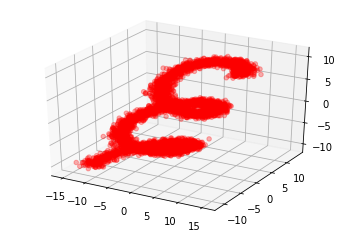

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Generating some data:
NSAMPLE = 5000

z_data = np.float32(np.random.uniform(-10.5, 10.5, NSAMPLE))
r_data = np.random.normal(size=NSAMPLE)
s_data = np.random.normal(size=NSAMPLE)
x_data = np.sin(0.75 * z_data) * 7.0 + z_data * 0.5 + r_data * 1.0
y_data = np.cos(0.80 * z_data) * 6.5 + z_data * 0.5 + s_data * 1.0

x_input = z_data.reshape((NSAMPLE, 1))
y_input = np.array([x_data,y_data])
y_input = y_input.T #reshape to (NSAMPLE,2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.3, c='r') #c=perf_down_sampled.moving
plt.show()

In [4]:
# Generate known parameters of a multivariate mixture of Gaussians
pi = np.array([0.2, 0.3, 0.5], dtype=np.float32)
mu = np.array([[10, 20],
               [20, 40],
               [30, 60]], dtype=np.float32)
sigma = np.array([[1, 1],
                  [2, 2],
                  [3, 3]], dtype=np.float32)

mvgmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=pi),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=mu,
        scale_diag=sigma)
)

X = mvgmm.sample(1000).numpy()
X, y = X[:,0][:,np.newaxis], X[:,1][:,np.newaxis]

n = len(X)
dataset = tf.data.Dataset \
    .from_tensor_slices((X,y)) \
    .shuffle(n).batch(n)

In [5]:
N_HIDDEN = 50
N_MIXES = 3
INPUT_DIMS = 1
OUTPUT_DIMS = 1

model = keras.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, INPUT_DIMS), activation='relu'))
model.add(keras.layers.Dense(N_HIDDEN, activation='relu'))
model.add(MDN(OUTPUT_DIMS, N_MIXES))

model.compile(loss=get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=keras.optimizers.Adam())
model.summary()


# history = model.fit(x=x_input, y=y_input, batch_size=128, epochs=300, validation_split=0.15, callbacks=[keras.callbacks.TerminateOnNaN()])
history = model.fit(x=X, y=y, batch_size=128, epochs=300, validation_split=0.15, callbacks=[keras.callbacks.TerminateOnNaN()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
mdn (MDN)                    (None, 9)                 459       
Total params: 3,109
Trainable params: 3,109
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
(None, 3) (None, 3) (None, 3)
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
(None, 3) (None, 3) (None, 3)
7/7 [==============================] - 1s 151ms/step - loss: 4048.8508 - val_loss: 152.1842
Epoch 2/300
7/7 [==============================] - 0s 12ms/step - loss: 112.8019 - val_loss: 75.5531
Epoch 3/300
7/7 [===============

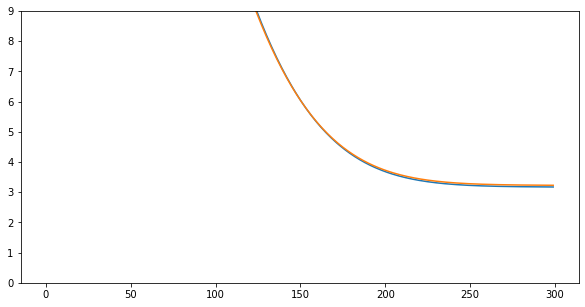

In [6]:
plt.figure(figsize=(10, 5))
plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [12]:
## Sample on some test data:
# x_test = np.float32(np.arange(-15,15,0.1))
# NTEST = x_test.size
# print("Testing:", NTEST, "samples.")
# x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

x_test = X
NTEST = X.size
# Make predictions from the model
y_test = model.predict(x_test)
# y_test contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Split up the mixture parameters (for future fun)
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, y_test)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, y_test)
pis = np.apply_along_axis((lambda a: softmax(a[-N_MIXES:])), 1, y_test)

# Sample from the predicted distributions
y_samples = np.apply_along_axis(sample_from_output, 1, y_test, OUTPUT_DIMS, N_MIXES, temp=1.0, sigma_temp=1.0)

(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) (3,)
(3,) (3,) 

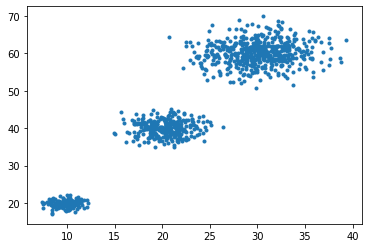

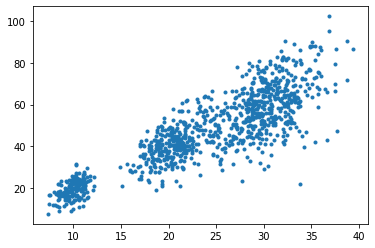

In [8]:
plt.plot(X, y, '.')
plt.show()
plt.plot(X, y_samples.reshape((1000,1)), '.')
plt.show()

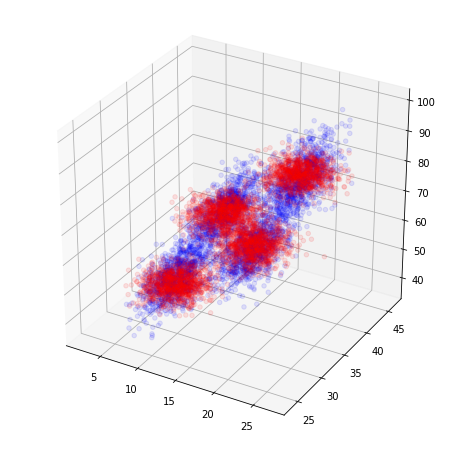

In [32]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, alpha=0.1, c='r')
ax.scatter(X[:,0], X[:,1], y_samples, alpha=0.1, c='b')
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

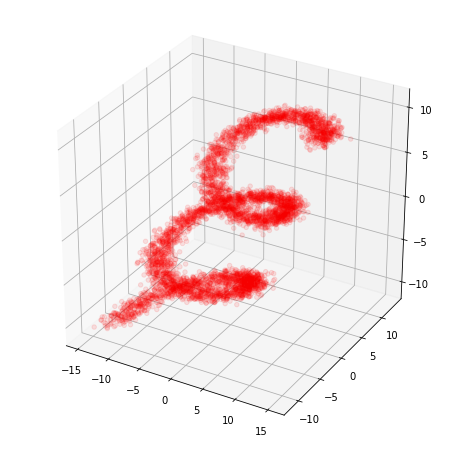

In [25]:
# Plot the predicted samples.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.1, c='r') #c=perf_down_sampled.moving
ax.scatter(y_samples.T[0], y_samples.T[1], x_test, alpha=0.1, c='b') #c=perf_down_sampled.moving
plt.show()

<IPython.core.display.Javascript object>


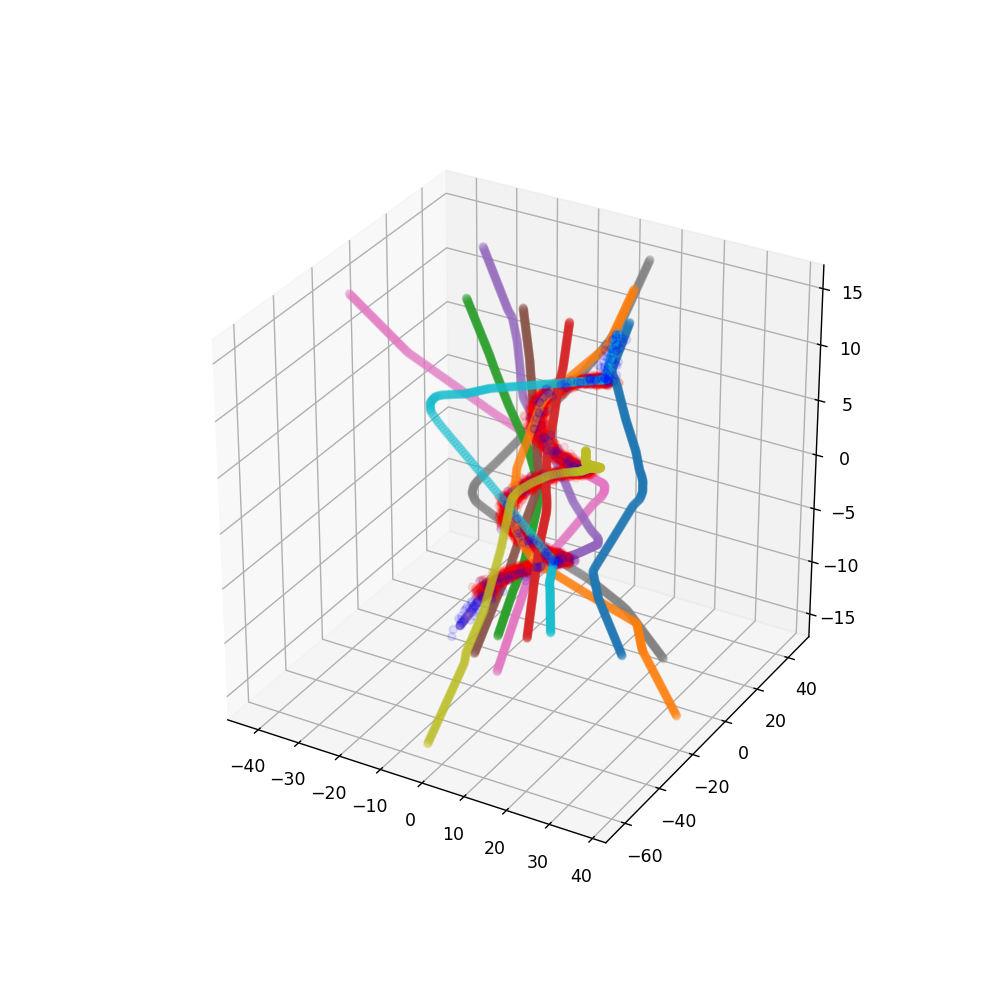

In [7]:
# Plot the means - this gives us some insight into how the model learns to produce the mixtures.
# Cool!

# Plot the predicted samples.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.1, c='r') #c=perf_down_sampled.moving
ax.scatter(y_samples.T[0], y_samples.T[1], x_test, alpha=0.1, c='b') #c=perf_down_sampled.moving
for m in range(N_MIXES):
    one_pair = mus[m*OUTPUT_DIMS:(m+1)*OUTPUT_DIMS]
    ax.scatter(mus[:,2*m], mus[:,2*m + 1] , x_test, marker='o',alpha=0.3)
plt.show()

<IPython.core.display.Javascript object>


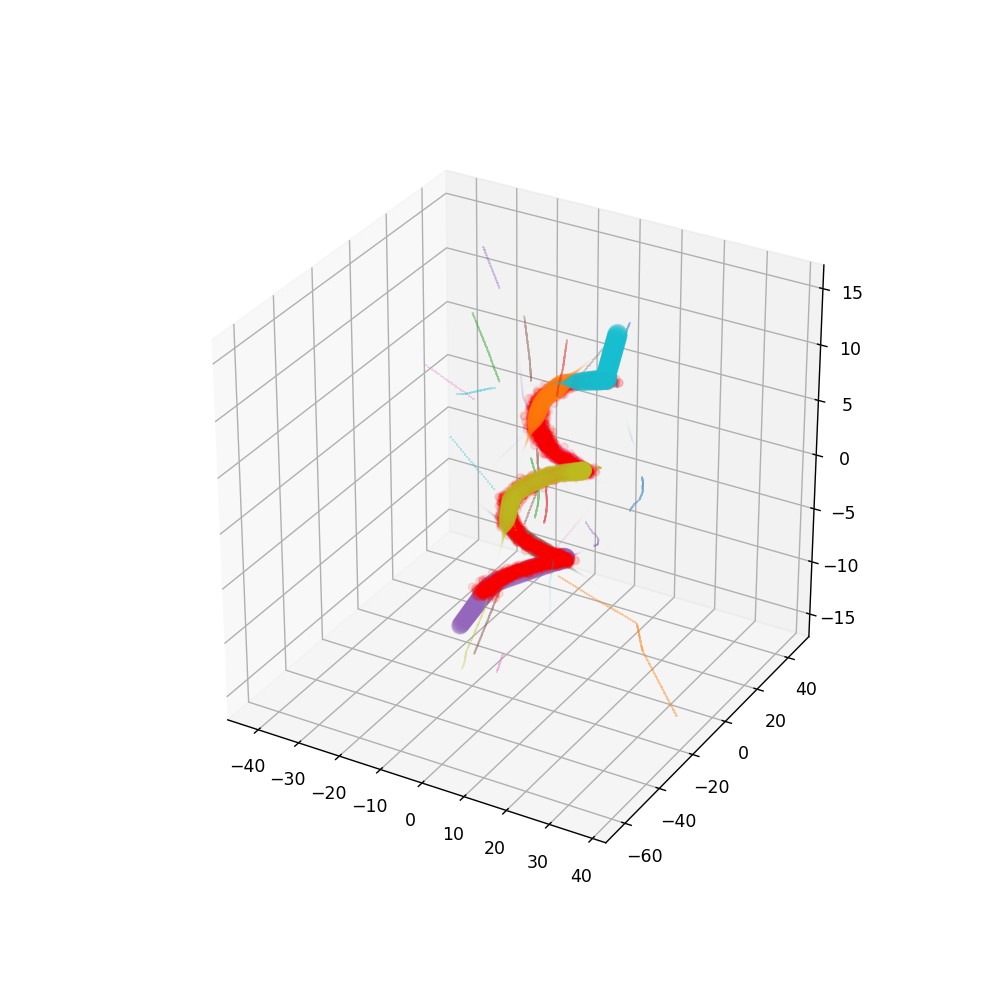

In [8]:
# Let's plot the variances and weightings of the means as well.

# Plot the predicted samples.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.1, c='r') #c=perf_down_sampled.moving
for m in range(N_MIXES):
    one_pair = mus[m*OUTPUT_DIMS:(m+1)*OUTPUT_DIMS]
    ax.scatter(mus[:,2*m], mus[:,2*m + 1] , x_test, s=100*sigs[:,2*m]*pis[:,m], marker='o',alpha=0.3)
plt.show()